Fashion MNIST

In [1]:
!pip install wandb
import wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.1 MB/s eta 0:00:00


In [2]:
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [3]:
!wandb login

#338ff25d87248e7f3e86e98c746e32fe09553c9e

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(48000, 28, 28)
(10000, 28, 28)
(12000, 28, 28)


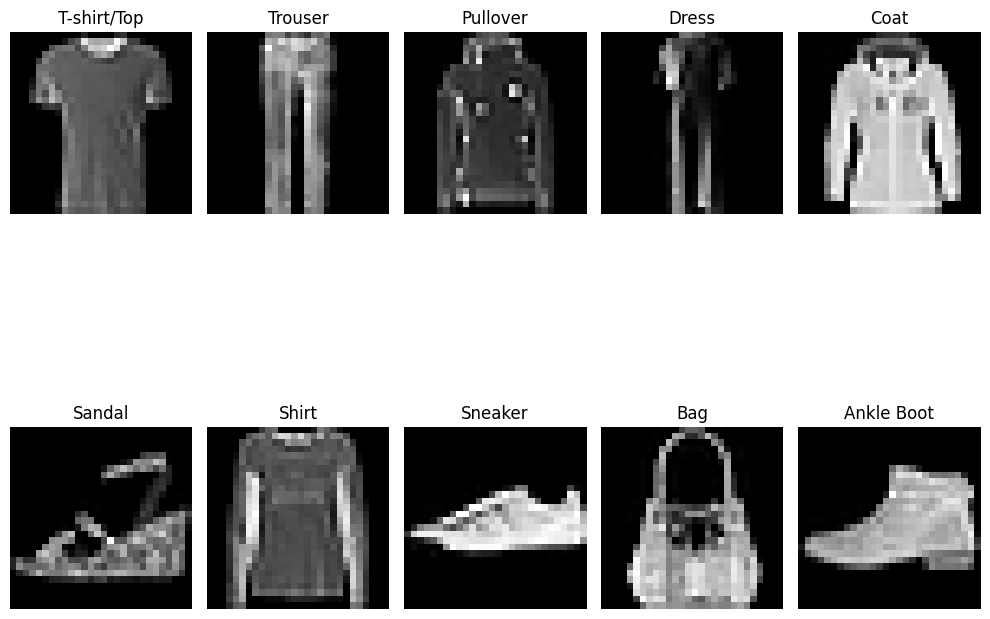

In [ ]:
# this array keeps track for ind of each class
images_ind = []
# classes which are present
class_names = ["T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

for i in range(10):
  for ind in range(X_train.shape[0]):
    if Y_train[ind] == i:
      images_ind.append(ind)
      break

# print(images_ind)

figure, axes = plt.subplots(2, 5, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
  ind = images_ind[i]
  ax.imshow(X_train[ind], cmap='gray')
  ax.axis('off')
  ax.set_title(class_names[i])

plt.tight_layout()
plt.show()  # Display the plot

In [ ]:
# normalsing and resisizing all the images
X_train = X_train/255.0
X_test  = X_test/255.0
X_val   = X_val/255.0

X_train = X_train.reshape(X_train.shape[0], 784).T
X_test = X_test.reshape(X_test.shape[0], 784).T
X_val = X_val.reshape(X_val.shape[0], 784).T
print(X_train.shape[0])


784


In [ ]:
def sigmoid(x):
    clip_x = np.clip(x, -500, 500)  # Cliping x to avoid overflow
    return 1 / (1 + np.exp(-clip_x))

In [ ]:
def Initialise(Layers, LayerWise, InputSize, OutputSize):
  # initialising weights and biases as a key value pair
  W = {}
  B = {}

  PreActivation = {}
  Activation = {}

  # adding input layer
  LayerWise.insert(0, InputSize)
  for i in range(Layers):
    W[i+1] = 0.01*np.random.randn(LayerWise[i+1], LayerWise[i])
    B[i+1] = 0.01*np.random.randn(LayerWise[i+1], 1)

    # preactivation and activation will have same size
    PreActivation[i+1] = np.zeros((LayerWise[i+1], 1))
    Activation[i+1]    = np.zeros((LayerWise[i+1], 1))
  del LayerWise[0]

  return W,B,PreActivation,Activation

def InitialiseEmptyWeightsAndBiases(Layers, LayerWise, InputSize):
  W = {}
  B = {}
  LayerWise.insert(0, InputSize)
  for i in range(Layers):
    W[i+1] = np.zeros((LayerWise[i+1], LayerWise[i]))
    B[i+1] = np.zeros((LayerWise[i+1], 1))
  del LayerWise[0]

  return W,B


In [ ]:
def FeedForward(x, W, B, preActivation, activation):
  # no of layers
  n = len(W)
  # here x can be list of elements at a go
  # softmax function
  y = x
  for i in range(1, n+1):
    preActivation[i] = np.dot(W[i], y) + B[i]
    activation[i] = sigmoid(preActivation[i])
    y = activation[i]

  # last layer we don't need activation
  y = preActivation[n]
  # doing softmax
  # doing the each column wise
  exp_y = np.exp(y - np.max(y, axis=0, keepdims=True))  # Improve numerical stability
  y = exp_y / np.sum(exp_y, axis=0, keepdims=True)
  return y

In [ ]:
def BackWardPropogation(X, y_corr, W, preActivation, activation, y_hat):
  # y_hat is the prediction
  # y_corr is the correct class

  dw = {}
  db = {}

  # these many points are there in the batch
  batchSize = y_corr.shape[0]
  da_l = y_hat

  ind = 0
  while ind < batchSize:
    da_l[y_corr[ind]][ind] -= 1
    ind += 1
  da = da_l


  activation[0] = X
  layer = len(W)
  dh = da #used for finding next layer
  while layer >= 1:
    dw[layer] = np.dot(da, activation[layer-1].T)
    db[layer] = da.sum(axis=1, keepdims=True)
    if layer > 1:
      dh = np.dot(W[layer].T, da)
      dg = activation[layer-1] * (1 - activation[layer-1])
      da = dh * dg
      # hedamant product

    layer -= 1


  return dw, db

In [ ]:
def findLoss(W, B, preActivation, activation):
  loss = 0
  for i in range(X_train.shape[1]):
    y = FeedForward(X_train[:,i, np.newaxis], W, B, preActivation, activation)
    # y returns the vector of the probabilities
    # y_train[i] is the correct prediction of the data
    loss = loss -1*math.log(y[Y_train[i]])

  return loss

In [ ]:
def FindAccuracy(W, B, preActivation, activation):
  n = X_test.shape[1]
  correct = 0
  y = FeedForward(X_train, W, B, preActivation, activation)

  for i in range(n):
    y_pred = np.argmax(y[:,i])
    if Y_train[i] == y_pred:
      correct += 1

  return (correct*100/ n)


In [ ]:
def gradient_decent(epochs, learningRate):
  layers = 3
  nodes  = [128, 64, 10]
  inputSize  = 28*28
  outputSize = 10
  W, B, preActivation, activation  = Initialise(layers, nodes, inputSize, outputSize)
  iteration = 0


  while(iteration < epochs):
    dW, dB = InitialiseEmptyWeightsAndBiases(layers, nodes, inputSize)

    for i in range(X_train.shape[1]):
      y = FeedForward(X_train[:,i, np.newaxis], W, B, preActivation, activation)
      # these are the partial derivates for one point
      dw, db = BackWardPropogation(X_train[:,i,np.newaxis], Y_train[i], W, preActivation, activation, y)

      # we need to update this for every layer
      for j in range(1, layers+1):
          dW[j] = dW[j] + dw[j]
          dB[j] = dB[j] + db[j]


    # overall updation
    # updating weights and baises
    for i in range(1, layers+1):
        W[i] = W[i] - learningRate*dW[i]
        B[i] = B[i] - learningRate*dB[i]

    # if iteration%5 == 0:
    print(FindAccuracy(W, B, preActivation, activation))
    iteration += 1



In [ ]:
gradient_decent(12, 0.00001)

9.09
8.74
9.19
9.51
9.98
10.33
10.63
10.89
11.22
11.58
12.03
12.39


In [ ]:
def StochasticGradientDecent(epochs, learningRate, batchSize):
  layers = 3
  nodes  = [128, 64, 10]
  inputSize  = 28*28
  outputSize = 10
  W, B, preActivation, activation  = Initialise(layers, nodes, inputSize, outputSize)
  iteration = 0
  empty_W, empty_B = InitialiseEmptyWeightsAndBiases(layers, nodes, inputSize)

  while(iteration < epochs):
    updates_W, updates_B = InitialiseEmptyWeightsAndBiases(layers, nodes, inputSize)
    i = 0
    while i < X_train.shape[1]:
      y = FeedForward(X_train[:, i:i+batchSize], W, B, preActivation, activation)
      # these are the partial derivates for one point
      dw, db = BackWardPropogation(X_train[:, i:i+batchSize], Y_train[i:i+batchSize], W, preActivation, activation, y)

      # we need to update this for every layer
      for j in range(1, layers+1):
          updates_W[j] = updates_W[j] + dw[j]
          updates_B[j] = updates_B[j] + db[j]

        # we will update the weights now
      for k in range(1, layers+1):
          W[k] = W[k] - learningRate*updates_W[k]
          B[k] = B[k] - learningRate*updates_B[k]

      # reinitiallising them to zeros
      updates_W, updates_B = InitialiseEmptyWeightsAndBiases(layers, nodes, inputSize)
      i += batchSize

    print(FindAccuracy(W, B, preActivation, activation))
    iteration += 1

In [ ]:
StochasticGradientDecent(10, 0.001, 2)

9.74
9.74
26.97
44.76
61.71
65.79
71.14
74.35
76.09
77.38


In [ ]:
StochasticGradientDecent(10, 0.001, 16)

10.9
9.74
28.61
48.24
60.94
65.48
70.58
73.62
75.88
77.44


In [ ]:
def MomentBasedGradientDecent(epochs, learningRate, batchSize, betha):
  layers = 3
  nodes  = [128, 64, 10]
  inputSize  = 28*28
  outputSize = 10
  W, B, preActivation, activation  = Initialise(layers, nodes, inputSize, outputSize)

  iteration = 0
  u_W, u_B = InitialiseEmptyWeightsAndBiases(layers, nodes, inputSize)
  # inititialising u to be zero

  while(iteration < epochs):
    updates_W, updates_B = InitialiseEmptyWeightsAndBiases(layers, nodes, inputSize)
    i = 0
    while i < X_train.shape[1]:
      # batch wise forward and backward passes
      y = FeedForward(X_train[:, i:i+batchSize], W, B, preActivation, activation)
      dw, db = BackWardPropogation(X_train[:, i:i+batchSize], Y_train[i:i+batchSize], W, preActivation, activation, y)

      # update the momentum with the gradient
      for k in range(1, layers+1):
        u_W[k] = u_W[k]*betha + dw[k]
        u_B[k] = u_B[k]*betha + db[k]

      # we will update the weights now with the momentum
      for k in range(1, layers+1):
          W[k] = W[k] - learningRate*u_W[k]
          B[k] = B[k] - learningRate*u_B[k]

      # next batch
      i += batchSize

    print(FindAccuracy(W, B, preActivation, activation))
    iteration += 1

In [ ]:
MomentBasedGradientDecent(2, 0.001, 16, 0.5)

53.42
73.71


In [ ]:
def NestrovBasedGradientDescent(epochs, learningRate, batchSize, beta):
  layers = 4
  nodes = [128, 128, 128, 10]
  inputSize = 28*28
  outputSize = 10
  W, B, preActivation, activation = Initialise(layers, nodes, inputSize, outputSize)
  iteration = 0
  u_W, u_B = InitialiseEmptyWeightsAndBiases(layers, nodes, inputSize)
  # initializing u to be zero

  while(iteration < epochs):
    i = 0
    while i < X_train.shape[1]:

      y = FeedForward(X_train[:, i:i+batchSize], W, B, preActivation, activation)
      dw, db = BackWardPropogation(X_train[:, i:i+batchSize], Y_train[i:i+batchSize], W, preActivation, activation, y)

      for k in range(1, layers+1):
          u_W[k] = u_W[k]*beta + dw[k]
          u_B[k] = u_B[k]*beta + db[k]

      for k in range(1, layers+1):
          W[k] = W[k] - learningRate*(beta* u_W[k]+ dw[k])
          B[k] = B[k] - learningRate*(beta* u_B[k]+ db[k])

      i += batchSize

    print(FindAccuracy(W, B, preActivation, activation))
    iteration += 1


In [ ]:
NestrovBasedGradientDescent(5, 0.001, 16, 0.9)

20.19
45.55
61.73
70.29
75.45


In [ ]:
NestrovBasedGradientDescent(10, 0.0001, 16, 0.9)

10.22
10.22
10.22
10.42
15.01
9.5
9.42
9.43
9.42
9.42


RMSPROP updation rule
$$v_t = \beta v_{t-1} + (1 - \beta)\nabla w_t^2$$
$$w_{t+1} = w_t - \frac{\eta}{\sqrt{v_t + \epsilon}} \nabla w_t$$



In [ ]:
def RMSPROP(epochs, learningRate, batchSize, betha, epsioln):
  layers = 3
  nodes  = [128, 128, 128, 10]
  inputSize  = 28*28
  outputSize = 10
  iteration = 0

  W, B, preActivation, activation  = Initialise(layers, nodes, inputSize, outputSize)
  v_W, v_B = InitialiseEmptyWeightsAndBiases(layers, nodes, inputSize)
  # inititialising u to be zero

  while(iteration < epochs):
    i = 0
    while i < X_train.shape[1]:
      y = FeedForward(X_train[:, i:i+batchSize], W, B, preActivation, activation)
      dw, db = BackWardPropogation(X_train[:, i:i+batchSize], Y_train[i:i+batchSize], W, preActivation, activation, y)

      # update the v values with the gradient
      for k in range(1, layers+1):
        v_W[k] = v_W[k]*betha + (1 - betha) * (dw[k] ** 2)
        v_B[k] = v_B[k]*betha + (1 - betha) * (db[k] ** 2)

      # we will update the weights now with the momentum
      for k in range(1, layers+1):
        W[k] = W[k] - (learningRate/np.sqrt(v_W[k] + epsioln))*dw[k]
        B[k] = B[k] - (learningRate/np.sqrt(v_B[k] + epsioln))*db[k]

      i += batchSize

    print(FindAccuracy(W, B, preActivation, activation))
    iteration += 1

In [ ]:
RMSPROP(8, 0.001, 16, 0.9, 0.005)

51.8
77.19
83.34
85.02
86.0
86.72
87.27
87.61


In [ ]:
RMSPROP(10, 0.0001, 64, 0.9, 0.0005)

9.74
21.52
36.86
42.52
47.53
53.33
57.92
64.31
69.32
71.49


In [ ]:
def ADAM(epochs, learningRate, batchSize, betha1, betha2, epsioln):
  layers = 3
  nodes  = [128, 64, 10]
  inputSize  = 28*28
  outputSize = 10
  iteration = 0

  W, B, preActivation, activation  = Initialise(layers, nodes, inputSize, outputSize)
  v_W, v_B = InitialiseEmptyWeightsAndBiases(layers, nodes, inputSize)
  m_W, m_B = InitialiseEmptyWeightsAndBiases(layers, nodes, inputSize)
  mhat_W, mhat_B = InitialiseEmptyWeightsAndBiases(layers, nodes, inputSize)
  vhat_W, vhat_B = InitialiseEmptyWeightsAndBiases(layers, nodes, inputSize)
  # inititialising u to be zero
  t = 1

  while(iteration < epochs):
    # this is used to compute the gradients
    i = 0
    while i < X_train.shape[1]:
      y = FeedForward(X_train[:, i:i+batchSize], W, B, preActivation, activation)
      dw, db = BackWardPropogation(X_train[:, i:i+batchSize], Y_train[i:i+batchSize], W, preActivation, activation, y)

      # updating the momentum
      for k in range(1, layers+1):
        m_W[k] = betha1*m_W[k] + (1 - betha1)*dw[k]
        m_B[k] = betha1*m_B[k] + (1 - betha1)*db[k]

        # finding m hat of W and B
        mhat_W[k] = m_W[k]/(1 - betha1 ** t)
        mhat_B[k] = m_B[k]/(1 - betha1 ** t)

      # update the v values with the gradient
      for k in range(1, layers+1):
        v_W[k] = v_W[k]*betha2 + (1 - betha2) * (dw[k] ** 2)
        v_B[k] = v_B[k]*betha2 + (1 - betha2) * (db[k] ** 2)

        # finding v hat of W and B
        vhat_W[k] = v_W[k]/(1 - betha2 ** t)
        vhat_B[k] = v_B[k]/(1 - betha2 ** t)

      # we will update the weights now with the momentum
      for k in range(1, layers+1):
        l2_norm_w = np.linalg.norm(vhat_W[k])
        l2_norm_b = np.linalg.norm(vhat_B[k])
        W[k] = W[k] - (learningRate/np.sqrt(l2_norm_w) + epsioln)*mhat_W[k]
        B[k] = B[k] - (learningRate/np.sqrt(l2_norm_b) + epsioln)*mhat_B[k]

      t += 1
      i += batchSize

    print(FindAccuracy(W, B, preActivation, activation))
    iteration += 1

In [ ]:
ADAM(10, 0.0001, 64, 0.9, 0.999, 0.005)

72.43
78.69
81.75
83.07
83.94
84.55
85.06
85.56
85.9
86.11


In [ ]:
def NADAM(epochs, learningRate, batchSize, betha1, betha2, epsioln):
  layers = 3
  nodes  = [128, 64, 10]
  inputSize  = 28*28
  outputSize = 10
  iteration = 0

  W, B, preActivation, activation  = Initialise(layers, nodes, inputSize, outputSize)
  v_W, v_B = InitialiseEmptyWeightsAndBiases(layers, nodes, inputSize)
  m_W, m_B = InitialiseEmptyWeightsAndBiases(layers, nodes, inputSize)
  mhat_W, mhat_B = InitialiseEmptyWeightsAndBiases(layers, nodes, inputSize)
  vhat_W, vhat_B = InitialiseEmptyWeightsAndBiases(layers, nodes, inputSize)
  # inititialising u to be zero
  t = 1

  while(iteration < epochs):
    # this is used to compute the gradients
    i = 0
    while i < X_train.shape[1]:
      y = FeedForward(X_train[:, i:i+batchSize], W, B, preActivation, activation)
      dw, db = BackWardPropogation(X_train[:, i:i+batchSize], Y_train[i:i+batchSize], W, preActivation, activation, y)

      # updating the momentum
      for k in range(1, layers+1):
        m_W[k] = betha1*m_W[k] + (1 - betha1)*dw[k]
        m_B[k] = betha1*m_B[k] + (1 - betha1)*db[k]

        # finding m hat of W and B
        mhat_W[k] = m_W[k]/(1 - betha1 ** t)
        mhat_B[k] = m_B[k]/(1 - betha1 ** t)

      # update the v values with the gradient
      for k in range(1, layers+1):
        v_W[k] = v_W[k]*betha2 + (1 - betha2) * (dw[k] ** 2)
        v_B[k] = v_B[k]*betha2 + (1 - betha2) * (db[k] ** 2)

        # finding v hat of W and B
        vhat_W[k] = v_W[k]/(1 - betha2 ** t)
        vhat_B[k] = v_B[k]/(1 - betha2 ** t)

      # we will update the weights now with the momentum
      for k in range(1, layers+1):
        l2_norm_w = np.linalg.norm(vhat_W[k])
        l2_norm_b = np.linalg.norm(vhat_B[k])
        W[k] = W[k] - (learningRate/np.sqrt(l2_norm_w) + epsioln)*(mhat_W[k]*betha1 + (1 - betha1)*dw[k]/(1 - betha1 ** t))
        B[k] = B[k] - (learningRate/np.sqrt(l2_norm_b) + epsioln)*(mhat_B[k]*betha1 + (1 - betha1)*db[k]/(1 - betha1 ** t))

      t += 1
      i += batchSize

    print(FindAccuracy(W, B, preActivation, activation))
    iteration += 1

In [ ]:
NADAM(10, 0.001, 16, 0.9, 0.999, 0.005)

72.97
81.62
84.1
85.02
85.65
86.11
86.61
86.88
87.22
87.5


In [ ]:
NADAM(10, 0.0001, 64, 0.9, 0.999, 0.005)

62.5
76.76
81.6
83.73
84.57
85.49
86.09
86.43
86.9
87.15


Writing in the class wise fashion

In [4]:
def relu(x):
  return np.maximum(0, x)

def sigmoid(x):
  clip_x = np.clip(x, -500, 500)  # Clipping x to avoid overflow
  return 1 / (1 + np.exp(-clip_x))

def _tanh(x):
  clip_x = np.clip(x, -500, 500)  # Clipping x for uniformity
  return np.tanh(clip_x)

In [17]:
## writing the code in the classwise fashion
class NeuralNetwork:
  def __init__(self, inputSize, hiddenLayers, outputSize, sizeOfHiddenLayers, batchSize, learningRate, initialisationType, optimiser, epochs, activationFunc, weightDecay, isWandb = False, lossFunc = "cross_entropy", dataset = "fashion_mnist"):
    # initialising model parameters
    nodes_in_layers = []
    for i in range(hiddenLayers):
      nodes_in_layers.append(sizeOfHiddenLayers)
    nodes_in_layers.append(outputSize)
    if dataset == "fashion_mnist":
      (X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
      X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

    # normalsing and resisizing all the images
    X_train = X_train/255.0
    X_test  = X_test/255.0
    X_val   = X_val/255.0

    X_train = X_train.reshape(X_train.shape[0], 784).T
    X_test = X_test.reshape(X_test.shape[0], 784).T
    X_val = X_val.reshape(X_val.shape[0], 784).T

    self.X_train = X_train
    self.Y_train = Y_train
    self.X_val   = X_val
    self.Y_val   = Y_val
    self.X_test  = X_test
    self.Y_test  = Y_test

    self.inputSize = inputSize
    self.outputSize= outputSize
    self.batchSize = batchSize
    self.layers = hiddenLayers + 1
    self.nodes  = nodes_in_layers
    self.initialisationType = initialisationType
    self.betha1 = 0.9
    self.betha2 = 0.999
    self.betha  = 0.9
    self.epsilon= 1e-8
    self.Weights= {}
    self.Baises = {}
    self.optimiser = optimiser
    self.epochs = epochs
    self.learningRate = learningRate
    self.activationFunc = activationFunc
    self.isWandb = isWandb
    self.weightDecay = weightDecay
    self.lossFunc = lossFunc # "cross_entropy" or "MSE"


  def Initialise(self):
    # initialising weights and biases as a key value pair
    W = {}
    B = {}

    PreActivation = {}
    Activation = {}

    # adding input layer
    LayerWise = self.nodes
    LayerWise.insert(0, self.inputSize)

    # initialisation of weights and baises
    for i in range(self.layers):
      if self.initialisationType == "random":
        W[i+1] = 0.01*np.random.randn(LayerWise[i+1], LayerWise[i])
        B[i+1] = 0.01*np.random.randn(LayerWise[i+1], 1)
      if self.initialisationType == "Xavier":
        W[i+1] = np.random.randn(LayerWise[i+1], LayerWise[i]) * np.sqrt(2. / (LayerWise[i] + LayerWise[i+1]))
        B[i+1] = np.zeros((LayerWise[i+1], 1))

      # preactivation and activation will have same size
      PreActivation[i+1] = np.zeros((LayerWise[i+1], 1))
      Activation[i+1]    = np.zeros((LayerWise[i+1], 1))

    del LayerWise[0]

    self.Weights = W
    self.Baises  = B
    self.PreActivation = PreActivation
    self.Activation = Activation

    return W,B,PreActivation,Activation

  def InitialiseEmptyWeightsAndBiases(self):
    W = {}
    B = {}
    LayerWise = self.nodes

    LayerWise.insert(0, self.inputSize)
    for i in range(self.layers):
      W[i+1] = np.zeros((LayerWise[i+1], LayerWise[i]))
      B[i+1] = np.zeros((LayerWise[i+1], 1))
    del LayerWise[0]

    return W,B

  def FeedForward(self, x, W, B, preActivation, activation):
    # no of layers
    n = len(W)
    y = x
    for i in range(1, n+1):
      preActivation[i] = np.dot(W[i], y) + B[i]
      if self.activationFunc == "sigmoid":
        activation[i] = sigmoid(preActivation[i])
      elif self.activationFunc == "tanh":
        activation[i] = _tanh(preActivation[i])
      elif self.activationFunc == "relu":
        activation[i] = relu(preActivation[i])

      y = activation[i]

    # last layer we don't need activation
    y = preActivation[n]
    # doing softmax doing the each column wise
    exp_y = np.exp(y - np.max(y, axis=0, keepdims=True))  # Improve numerical stability
    y = exp_y / np.sum(exp_y, axis=0, keepdims=True)
    return y

  def BackWardPropogation(self, X, y_corr, W, preActivation, activation, y_hat):
    # y_hat is the prediction and y_corr is the correct class
    dw = {}
    db = {}

    # these many points are there in the batch
    batchSize = y_corr.shape[0]
    da_l = y_hat

    ind = 0
    while ind < batchSize:
      da_l[y_corr[ind]][ind] -= 1
      ind += 1
    da = da_l

    activation[0] = X
    layer = len(W)
    dh = da #used for finding next layer
    while layer >= 1:
      dw[layer] = np.dot(da, activation[layer-1].T)
      db[layer] = da.sum(axis=1, keepdims=True)
      if layer > 1:
        dh = np.dot(W[layer].T, da)
        if self.activationFunc == "sigmoid":
          dg = activation[layer-1] * (1 - activation[layer-1])
        elif self.activationFunc == "tanh":
          dg = (1 + activation[layer-1]) * (1 - activation[layer-1])
        elif self.activationFunc == "relu":
          dg = np.where(preActivation[layer-1] > 0, 1, 0)

        # dg = activation[layer-1] * (1 - activation[layer-1])
        da = dh * dg
        # hedamant product
      layer -= 1

    for i in range(1, self.layers+1):
      dw[i] = dw[i] + self.weightDecay*W[i]

    return dw, db

  def FindAccuracyAndLoss(self, W, B, data, labels):
    n = data.shape[1]
    correct = 0

    #running the data on the weights and baises
    y = data
    for i in range(1, self.layers+1):
      preActivation = np.dot(W[i], y) + B[i]

      if self.activationFunc == "sigmoid":
        activation = sigmoid(preActivation)
      elif self.activationFunc == "tanh":
        activation = _tanh(preActivation)
      elif self.activationFunc == "relu":
        activation = relu(preActivation)
      y = activation

    # last layer we don't need activation
    y = preActivation
    # doing softmax doing the each column wise
    exp_y = np.exp(y - np.max(y, axis=0, keepdims=True))  # Improve numerical stability
    y = exp_y / np.sum(exp_y, axis=0, keepdims=True)
    loss = 0

    for i in range(n):
      y_pred = np.argmax(y[:,i])
      if labels[i] == y_pred:
        correct += 1

      loss += -1*np.log(y[:,i][labels[i]] + 1e-9)

    return (correct*100/ n), (loss/n)

  def SGD(self):
    W, B, preActivation, activation  = self.Initialise()
    iteration = 0
    layers = self.layers
    empty_W, empty_B = self.InitialiseEmptyWeightsAndBiases()

    while(iteration < self.epochs):
      i = 0
      while i < self.X_train.shape[1]:
        y = self.FeedForward(self.X_train[:, i:i+self.batchSize], W, B, preActivation, activation)
        # these are the partial derivates for one point
        dw, db = self.BackWardPropogation(self.X_train[:, i:i+self.batchSize], self.Y_train[i:i+self.batchSize], W, preActivation, activation, y)

        # we will update the weights now
        for k in range(1, layers+1):
            W[k] = W[k] - self.learningRate*dw[k]
            B[k] = B[k] - self.learningRate*db[k]

        i += self.batchSize
      acuu, loss = self.FindAccuracyAndLoss(W, B, self.X_train, self.Y_train)
      v_acc, v_loss = self.FindAccuracyAndLoss(W, B, self.X_val, self.Y_val)
      if self.isWandb == True:
        wandb.log({'accuracy': acuu})
        wandb.log({'loss': loss})
        wandb.log({'v_accuracy': v_acc})
        wandb.log({'v_loss': v_loss})
      print(acuu, loss, v_acc, v_loss)
      iteration += 1

    self.Weights = W
    self.Baises  = B

  def MomentBasedGradientDecent(self):
    W, B, preActivation, activation  = self.Initialise()
    iteration = 0
    u_W, u_B = self.InitialiseEmptyWeightsAndBiases()
    # inititialising u to be zero

    while(iteration < self.epochs):
      i = 0
      while i < self.X_train.shape[1]:
        # batch wise forward and backward passes
        y = self.FeedForward(self.X_train[:, i:i+self.batchSize], W, B, preActivation, activation)
        dw, db = self.BackWardPropogation(self.X_train[:, i:i+self.batchSize], self.Y_train[i:i+self.batchSize], W, preActivation, activation, y)

        # update the momentum with the gradient
        for k in range(1, self.layers+1):
          u_W[k] = u_W[k]*self.betha + dw[k]
          u_B[k] = u_B[k]*self.betha + db[k]

        # we will update the weights now with the momentum
        for k in range(1, self.layers+1):
            W[k] = W[k] - self.learningRate*u_W[k]
            B[k] = B[k] - self.learningRate*u_B[k]

        # next batch
        i += self.batchSize
      acuu, loss = self.FindAccuracyAndLoss(W, B, self.X_train, self.Y_train)
      v_acc, v_loss = self.FindAccuracyAndLoss(W, B, self.X_val, self.Y_val)
      if self.isWandb == True:
        wandb.log({'accuracy': acuu})
        wandb.log({'loss': loss})
        wandb.log({'v_accuracy': v_acc})
        wandb.log({'v_loss': v_loss})
      print(acuu, loss, v_acc, v_loss)
      iteration += 1

    self.Weights = W
    self.Baises  = B

  def NestrovBasedGradientDescent(self):
    iteration = 0
    W, B, preActivation, activation = self.Initialise()
    u_W, u_B = self.InitialiseEmptyWeightsAndBiases()
    # initializing u to be zero

    while(iteration < self.epochs):
      i = 0
      while i < self.X_train.shape[1]:

        y = self.FeedForward(self.X_train[:, i:i+self.batchSize], W, B, preActivation, activation)
        dw, db = self.BackWardPropogation(self.X_train[:, i:i+self.batchSize], self.Y_train[i:i+self.batchSize], W, preActivation, activation, y)

        for k in range(1, self.layers+1):
            u_W[k] = u_W[k]*self.betha + dw[k]
            u_B[k] = u_B[k]*self.betha + db[k]

        for k in range(1, self.layers+1):
            W[k] = W[k] - self.learningRate*(self.betha* u_W[k]+ dw[k])
            B[k] = B[k] - self.learningRate*(self.betha* u_B[k]+ db[k])

        i += self.batchSize
      acuu, loss = self.FindAccuracyAndLoss(W, B, self.X_train, self.Y_train)
      v_acc, v_loss = self.FindAccuracyAndLoss(W, B, self.X_val, self.Y_val)
      if self.isWandb == True:
        wandb.log({'accuracy': acuu})
        wandb.log({'loss': loss})
        wandb.log({'v_accuracy': v_acc})
        wandb.log({'v_loss': v_loss})
      print(acuu, loss, v_acc, v_loss)
      iteration += 1

    self.Weights = W
    self.Baises  = B

  def RMSPROP(self):
    iteration = 0
    epochs = self.epochs
    layers = self.layers
    batchSize = self.batchSize
    betha = self.betha
    W, B, preActivation, activation  = self.Initialise()
    v_W, v_B = self.InitialiseEmptyWeightsAndBiases()
    # inititialising u to be zero

    while(iteration < epochs):
      i = 0
      while i < self.X_train.shape[1]:
        y = self.FeedForward(self.X_train[:, i:i+batchSize], W, B, preActivation, activation)
        dw, db = self.BackWardPropogation(self.X_train[:, i:i+batchSize], self.Y_train[i:i+batchSize], W, preActivation, activation, y)

        # update the v values with the gradient
        for k in range(1, layers+1):
          v_W[k] = v_W[k]*betha + (1 - betha) * (dw[k] ** 2)
          v_B[k] = v_B[k]*betha + (1 - betha) * (db[k] ** 2)

        # we will update the weights now with the momentum
        for k in range(1, layers+1):
          W[k] = W[k] - (self.learningRate/np.sqrt(v_W[k] + self.epsilon))*dw[k]
          B[k] = B[k] - (self.learningRate/np.sqrt(v_B[k] + self.epsilon))*db[k]

        i += batchSize
      acuu, loss = self.FindAccuracyAndLoss(W, B, self.X_train, self.Y_train)
      v_acc, v_loss = self.FindAccuracyAndLoss(W, B, self.X_val, self.Y_val)
      if self.isWandb == True:
        wandb.log({'accuracy': acuu})
        wandb.log({'loss': loss})
        wandb.log({'v_accuracy': v_acc})
        wandb.log({'v_loss': v_loss})
      print(acuu, loss, v_acc, v_loss)
      iteration += 1

    self.Weights = W
    self.Baises  = B

  def ADAM(self):
    iteration = 0
    epochs = self.epochs
    layers = self.layers
    batchSize = self.batchSize

    W, B, preActivation, activation  = self.Initialise()
    v_W, v_B = self.InitialiseEmptyWeightsAndBiases()
    m_W, m_B = self.InitialiseEmptyWeightsAndBiases()
    mhat_W, mhat_B = self.InitialiseEmptyWeightsAndBiases()
    vhat_W, vhat_B = self.InitialiseEmptyWeightsAndBiases()
    # inititialising u to be zero
    t = 1

    while(iteration < epochs):
      # this is used to compute the gradients
      i = 0
      while i < self.X_train.shape[1]:
        y = self.FeedForward(self.X_train[:, i:i+batchSize], W, B, preActivation, activation)
        dw, db = self.BackWardPropogation(self.X_train[:, i:i+batchSize], self.Y_train[i:i+batchSize], W, preActivation, activation, y)

        # updating the momentum
        for k in range(1, layers+1):
          m_W[k] = self.betha1*m_W[k] + (1 - self.betha1)*dw[k]
          m_B[k] = self.betha1*m_B[k] + (1 - self.betha1)*db[k]

          # finding m hat of W and B
          mhat_W[k] = m_W[k]/(1 - self.betha1 ** t)
          mhat_B[k] = m_B[k]/(1 - self.betha1 ** t)

        # update the v values with the gradient
        for k in range(1, layers+1):
          v_W[k] = v_W[k]*self.betha2 + (1 - self.betha2) * (dw[k] ** 2)
          v_B[k] = v_B[k]*self.betha2 + (1 - self.betha2) * (db[k] ** 2)

          # finding v hat of W and B
          vhat_W[k] = v_W[k]/(1 - self.betha2 ** t)
          vhat_B[k] = v_B[k]/(1 - self.betha2 ** t)

        # we will update the weights now with the momentum
        for k in range(1, layers+1):
          l2_norm_w = np.linalg.norm(vhat_W[k])
          l2_norm_b = np.linalg.norm(vhat_B[k])
          W[k] = W[k] - (self.learningRate/np.sqrt(l2_norm_w) + self.epsilon)*mhat_W[k]
          B[k] = B[k] - (self.learningRate/np.sqrt(l2_norm_b) + self.epsilon)*mhat_B[k]

        t += 1
        i += self.batchSize

      acuu, loss = self.FindAccuracyAndLoss(W, B, self.X_train, self.Y_train)
      v_acc, v_loss = self.FindAccuracyAndLoss(W, B, self.X_val, self.Y_val)
      if self.isWandb == True:
        wandb.log({'accuracy': acuu})
        wandb.log({'loss': loss})
        wandb.log({'v_accuracy': v_acc})
        wandb.log({'v_loss': v_loss})
      print(acuu, loss, v_acc, v_loss)
      iteration += 1

    self.Weights = W
    self.Baises  = B

  def NADAM(self):
    iteration = 0
    epochs = self.epochs
    layers = self.layers
    W, B, preActivation, activation  = self.Initialise()
    v_W, v_B = self.InitialiseEmptyWeightsAndBiases()
    m_W, m_B = self.InitialiseEmptyWeightsAndBiases()
    mhat_W, mhat_B = self.InitialiseEmptyWeightsAndBiases()
    vhat_W, vhat_B = self.InitialiseEmptyWeightsAndBiases()
    # inititialising u to be zero
    t = 1

    while(iteration < self.epochs):
      # this is used to compute the gradients
      i = 0
      while i < self.X_train.shape[1]:
        y = self.FeedForward(self.X_train[:, i:i+self.batchSize], W, B, preActivation, activation)
        dw, db = self.BackWardPropogation(self.X_train[:, i:i+self.batchSize], self.Y_train[i:i+self.batchSize], W, preActivation, activation, y)

        # updating the momentum
        for k in range(1, layers+1):
          m_W[k] = self.betha1*m_W[k] + (1 - self.betha1)*dw[k]
          m_B[k] = self.betha1*m_B[k] + (1 - self.betha1)*db[k]

          # finding m hat of W and B
          mhat_W[k] = m_W[k]/(1 - self.betha1 ** t)
          mhat_B[k] = m_B[k]/(1 - self.betha1 ** t)

        # update the v values with the gradient
        for k in range(1, layers+1):
          v_W[k] = v_W[k]*self.betha2 + (1 - self.betha2) * (dw[k] ** 2)
          v_B[k] = v_B[k]*self.betha2 + (1 - self.betha2) * (db[k] ** 2)

          # finding v hat of W and B
          vhat_W[k] = v_W[k]/(1 - self.betha2 ** t)
          vhat_B[k] = v_B[k]/(1 - self.betha2 ** t)

        # we will update the weights now with the momentum
        for k in range(1, layers+1):
          l2_norm_w = np.linalg.norm(vhat_W[k])
          l2_norm_b = np.linalg.norm(vhat_B[k])
          W[k] = W[k] - (self.learningRate/np.sqrt(l2_norm_w) + self.epsilon)*(mhat_W[k]*self.betha1 + (1 - self.betha1)*dw[k]/(1 - self.betha1 ** t))
          B[k] = B[k] - (self.learningRate/np.sqrt(l2_norm_b) + self.epsilon)*(mhat_B[k]*self.betha1 + (1 - self.betha1)*db[k]/(1 - self.betha1 ** t))

        t += 1
        i += self.batchSize

      acuu, loss = self.FindAccuracyAndLoss(W, B, self.X_train, self.Y_train)
      v_acc, v_loss = self.FindAccuracyAndLoss(W, B, self.X_val, self.Y_val)
      if self.isWandb == True:
        wandb.log({'accuracy': acuu})
        wandb.log({'loss': loss})
        wandb.log({'v_accuracy': v_acc})
        wandb.log({'v_loss': v_loss})
      print(acuu, loss, v_acc, v_loss)
      iteration += 1

    self.Weights = W
    self.Baises  = B

  def fit(self):
    if self.optimiser == "sgd":
      self.SGD()
    if self.optimiser == "momentum":
      self.MomentBasedGradientDecent()
    if self.optimiser == "nestrov":
      self.NestrovBasedGradientDescent()
    if self.optimiser == "rmsprop":
      self.RMSPROP()
    if self.optimiser == "adam":
      self.ADAM()
    if self.optimiser == "nadam":
      self.NADAM()


In [ ]:
model = NeuralNetwork(inputSize = 784, hiddenLayers = 4, outputSize = 10, sizeOfHiddenLayers = 64, batchSize = 32, learningRate = 0.001, initialisationType = "Xavier", optimiser = "nadam", activationFunc="relu",weightDecay = 0.0005, epochs = 4)
model.fit()

In [ ]:
def main():
    wandb.init(project="Assignment 1")
    config = wandb.config
    run_name = f"{config.optimiser}_{config.activation}_{config.hidden_layers}_{config.hidden_layer_size}_{config.batch_size}"

    # Set the run name
    wandb.run.name = run_name
    wandb.run.save()

    # Define and train the model as before
    model = NeuralNetwork(inputSize = 784, hiddenLayers = config.hidden_layers, outputSize = 10, sizeOfHiddenLayers = config.hidden_layer_size, batchSize = config.batch_size, learningRate = config.learning_rate, initialisationType = config.weights_initialisation, optimiser = config.optimiser, activationFunc=config.activation, epochs = config.epochs,weightDecay = config.weight_decay, isWandb = True)
    model.fit()
    wandb.finish()

sweep_config = {
    'method': 'bayes',
    'name' : 'sweep cross entropy',
    'metric': {
      'name': 'v_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'epochs': {
            'values': [5,10]
        },
        'hidden_layers': {
          'values': [3, 4, 5]
        },
        'hidden_layer_size':{
            'values':[32,64,128]
        },
        'weight_decay': {
            'values':[0, 0.0005, 0.5]
        },
        'batch_size': {
            'values': [16, 32, 64]
        },
        'activation': {
            'values': ['sigmoid','relu','tanh']
        },
        'optimiser': {
            'values': ['sgd', 'momentum', 'nestrov', 'rmsprop', 'adam', 'nadam']
        },
        'weights_initialisation': {
            'values': ['random', 'Xavier']
        },
        'learning_rate': {
            'values':[1e-2,1e-3,1e-4]
        },
    }
}


sweep_id = wandb.sweep(sweep=sweep_config,project='Assignment 1')
wandb.agent(sweep_id , function = main , count = 150)
wandb.finish()

In [ ]:
## todo tasks

#  -- Add different activation functions and derivaties still linear is left
#  -- L2 regularisation by adding epsilon * alpha * w at each updation so send this at the dw find
#